In [85]:
import pandas as pd
import numpy as np
from datetime import datetime

In [86]:
train_data = pd.read_csv('train_data.csv')
train_data.head()

,Created,CancelTime,DepartureTime,BillID,TicketID,ReserveStatus,UserID,Male,Price,CouponDiscount,...,Domestic,VehicleType,VehicleClass,TripReason,Vehicle,Cancel,HashPassportNumber_p,HashEmail,BuyerMobile,NationalCode
0,2022-07-26 13:33:20.457,NaN,2022-07-26 16:30:00,38428546,7445571.0,3,NaN,True,1180000.0,0.0,...,1,VIPمانیتوردار-شارژراختصاصی تخت شو مارال (جدید)...,True,Work,Bus,0,NaN,NaN,302222356019,330024570
1,2022-10-27 23:07:01.837,2022-10-27 23:26:39.070,2022-10-29 09:45:00,39768762,7762719.0,5,NaN,False,1050000.0,0.0,...,1,classicus 2+2,True,Int,Bus,1,NaN,NaN,900764168521,995520696
2,2022-09-12 11:01:13.607,NaN,2022-10-03 18:35:00,39128001,2327596.0,5,800398.0,False,4674000.0,0.0,...,1,فوکر 100,False,Int,Plane,0,NaN,1c44d7a76b52341fa12dcfa993138576befcc9ebf01d14...,749804783291,979382950
3,2022-08-08 17:43:35.840,NaN,2022-08-08 22:30:00,38606546,7495440.0,3,NaN,True,1200000.0,0.0,...,1,VIPدرسا+مانیتوردار+شارژراختصاصی+پذیرایی,True,Work,Bus,0,NaN,NaN,781396205677,911237229
4,2022-11-01 15:12:56.823,NaN,2022-11-03 11:30:00,39822185,2356902.0,5,NaN,True,6222000.0,0.0,...,1,NaN,False,Work,Plane,0,NaN,bb38b345aec02255e31d178492907175c5984f2a1f5b59...,524576220177,727496008


In [87]:
train_data.Created = train_data.Created.apply(lambda x :datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
train_data.DepartureTime = train_data.DepartureTime.apply(lambda x :datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [88]:
train_data['time'] = train_data.DepartureTime - train_data.Created
train_data['time'] = train_data['time'].apply(lambda x : x.total_seconds())

In [89]:
train_data = train_data.drop('CancelTime', axis=1)
train_data = train_data.drop('Created', axis=1)

train_data = train_data.drop('BillID', axis=1)

train_data = train_data.drop('UserID', axis=1)

train_data = train_data.drop(train_data[train_data['Price'] == 0.0].index)
train_data = train_data.drop(train_data[train_data['Price'] == -1514000.0].index)
train_data = train_data.drop('VehicleType', axis=1)


In [90]:
lst = train_data.groupby('From')['VehicleClass'].apply(lambda x : x.mode())

In [91]:
train_data.loc[train_data.VehicleClass.isnull(), 'VehicleClass'] = train_data.From.apply(lambda x :lst[x][0] if x in lst else None)
train_data.loc[train_data.VehicleClass.isnull(), 'VehicleClass'] = True

In [92]:
train_data = train_data.drop('HashPassportNumber_p', axis=1)
train_data = train_data.drop('HashEmail', axis=1)
train_data = train_data.drop('BuyerMobile', axis=1)
train_data = train_data.drop('NationalCode', axis=1)

In [93]:
train_data['month'] = train_data['DepartureTime'].dt.month

In [94]:
train_data = train_data.drop('DepartureTime', axis=1)
train_data = train_data.drop('From', axis=1)
train_data = train_data.drop('To', axis=1)

In [95]:
train_data.VehicleClass = train_data.VehicleClass.astype('bool')

In [96]:
mapping = {'Int' : 0,
           'Work' : 1}

In [97]:
train_data.TripReason = train_data.TripReason.map(mapping)

In [98]:
train_data = pd.get_dummies(train_data, columns=['Vehicle'])

In [99]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101015 entries, 0 to 101016
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   TicketID                    101015 non-null  float64
 1   ReserveStatus               101015 non-null  int64  
 2   Male                        101015 non-null  bool   
 3   Price                       101015 non-null  float64
 4   CouponDiscount              101015 non-null  float64
 5   Domestic                    101015 non-null  int64  
 6   VehicleClass                101015 non-null  bool   
 7   TripReason                  101015 non-null  int64  
 8   Cancel                      101015 non-null  int64  
 9   time                        101015 non-null  float64
 10  month                       101015 non-null  int32  
 11  Vehicle_Bus                 101015 non-null  bool   
 12  Vehicle_InternationalPlane  101015 non-null  bool   
 13  Vehicle_Plane      

In [100]:
x = train_data.drop('Cancel', axis=1)
y = train_data['Cancel']

In [101]:
#StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=scaler.feature_names_in_)

In [102]:
#train_test_split
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)

In [103]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
n0 = ytrain[ytrain == 0].size
n1 = ytrain[ytrain == 1].size
W = {0 : n1/(n0+n1), 1:n0/(n0+n1)}
model = RandomForestClassifier(n_estimators = 50, max_depth=30, random_state=42, class_weight=W)
model.fit(xtrain, ytrain)

RandomForestClassifier(class_weight={0: 0.15052219967331584,
                                     1: 0.8494778003266842},
                       max_depth=30, n_estimators=50, random_state=42)

In [104]:
# predict test samples
y_pred = model.predict(xtest)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17068
           1       0.99      0.91      0.95      3135

    accuracy                           0.99     20203
   macro avg       0.99      0.96      0.97     20203
weighted avg       0.99      0.99      0.99     20203



<Axes: >

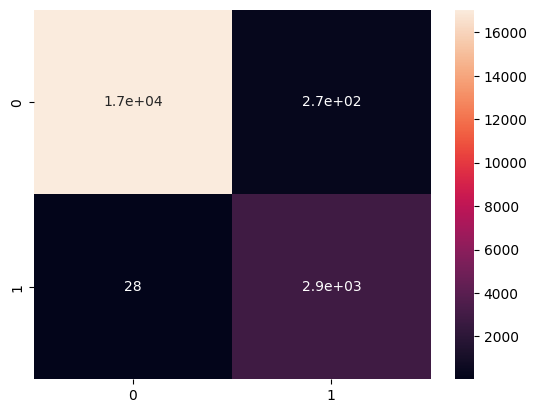

In [105]:
# evaluate model
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

print(classification_report(ytest, y_pred))
sns.heatmap(confusion_matrix(y_pred, ytest), annot=True)